# A He-burning Network

Here we create a network that can be used as an $\alpha$-chain for modeling He detonations, and includes some of the iron group.  It is similar in goals to the classic `aprox19` network, but it has some additional rates that are important.

In [1]:
import pynucastro as pyna

## Assembling our library

### Core nuclei

We start with a list of nuclei, including all $\alpha$-nuclei up to ${}^{56}\mathrm{Ni}$.
We also add the intermediate nuclei that would participate in $(\alpha,p)(p,\gamma)$ reactions,
as well as a few more nuclei, including those identified by [Shen & Bildsten 2009](https://ui.adsabs.harvard.edu/abs/2009ApJ...699.1365S/abstract) for bypassing the ${}^{12}\mathrm{C}(\alpha,\gamma){}^{16}\mathrm{O}$ rate.  These rates are not present in the classic `aprox` networks, but can
be very important for the ignition of a detonation.

In [2]:
nuclei = ["p",
          "he4", "c12", "o16", "ne20", "mg24", "si28", "s32",
          "ar36", "ca40", "ti44", "cr48", "fe52", "ni56",
          "al27", "p31", "cl35", "k39", "sc43", "v47", "mn51", "co55",
          "n13", "n14", "f18", "ne21", "na22", "na23"]

For our initial library, we take all of the ReacLib rates that link these.

In [3]:
reaclib_lib = pyna.ReacLibLibrary()
core_lib = reaclib_lib.linking_nuclei(nuclei)

Since we didn't include neutrons in our list of nuclei, we are missing some potentially important rates, which we now add manually.  However, we do not want to carry neutrons, so we modify the endpoints of these reactions, using {py:obj}`ModifiedRate <pynucastro.rates.modified_rate.ModifiedRate>` to assume
that the original $(X, n)$ reaction is immediately followed by a neutron capture.

In [4]:
other_rates = [("c12(c12,n)mg23", "mg24"),
               ("o16(o16,n)s31", "s32"),
               ("o16(c12,n)si27", "si28")]

for r, mp in other_rates:
    _r = reaclib_lib.get_rate_by_name(r)
    new_rate = pyna.ModifiedRate(_r, new_products=[mp])    
    core_lib += pyna.Library(rates=[new_rate])

### Iron group

Next we'll add some more nuclei in the iron group.

In [5]:
iron_peak = ["n", "p", "he4",
             "mn51",
             "fe52", "fe53", "fe54", "fe55", "fe56",
             "co55", "co56", "co57",
             "ni56", "ni57", "ni58"]

We want to get the rates from both ReacLib and our tabulate weak rate library.  Also note that we make sure there is some overlap with the list of nuclei used previously, so these rates will connect to what we already assembled.

In [6]:
iron_reaclib = reaclib_lib.linking_nuclei(iron_peak)

weak_lib = pyna.TabularLibrary()
iron_weak_lib = weak_lib.linking_nuclei(iron_peak)

Finally, we assemble a `Library` containing all the rates we selected.

In [7]:
all_lib = core_lib + iron_reaclib + iron_weak_lib

## Detailed balance

We want to replace the reverse rates from ReacLib by rederiving them via detailed balance, and including the partition functions.

In [8]:
rates_to_derive = all_lib.backward().get_rates()

# now for each of those derived rates, look to see if the pair exists

for r in rates_to_derive:
    fr = all_lib.get_rate_by_nuclei(r.products, r.reactants)
    if fr:
        all_lib.remove_rate(r)
        d = pyna.DerivedRate(rate=fr, compute_Q=True, use_pf=True, use_unreliable_spins=True)
        all_lib.add_rate(d)

## Removing duplicates

There will be some duplicate rates now because we pulled rates both from ReacLib and from tabulated sources.  Here we keep the tabulated version of any duplicate rates.

In [9]:
all_lib.eliminate_duplicates()

## Creating the network

Now that we have our library, we can make a network.  This can be a `RateCollection`, `PythonNetwork`, or `AmrexAstroCxxNetwork`.  

```{note}
For a `SimpleCxxNetwork` or `FortranNetwork`, we do not currently support partition functions, so we would need to comment out the above cell that rederives the reverse rates via detailed balance.
```

In [10]:
net = pyna.PythonNetwork(libraries=[all_lib])

### Rate approximations

Next, we will do the $(\alpha,p)(p,\gamma)$ approximation and eliminate the intermediate nuclei

In [11]:
net.make_ap_pg_approx(intermediate_nuclei=["cl35", "k39", "sc43", "v47"])
net.remove_nuclei(["cl35", "k39", "sc43", "v47"])

We will also approximate some of the neutron captures:

In [12]:
net.make_nn_g_approx(intermediate_nuclei=["fe53", "fe55", "ni57"])
net.remove_nuclei(["fe53", "fe55", "ni57"])

and finally, make some of the protons into NSE protons

In [13]:
net.make_nse_protons(48)

### Final stats

The final network has a variety of different rates supported by pynucastro

In [14]:
net.summary()

Network summary
---------------
  explicitly carried nuclei: 31
  approximated-out nuclei: 7
  inert nuclei (included in carried): 0

  total number of rates: 154

  rates explicitly connecting nuclei: 115
  hidden rates: 39

  reaclib rates: 67
  tabular rates: 6
  approximate rates: 14
  derived rates: 64
  modified rates: 3
  custom rates: 0


In all, there are 31 nuclei, but with the approximations, this behaves like a 38-nuclei network.

## Visualizing the network

Let's visualize the network

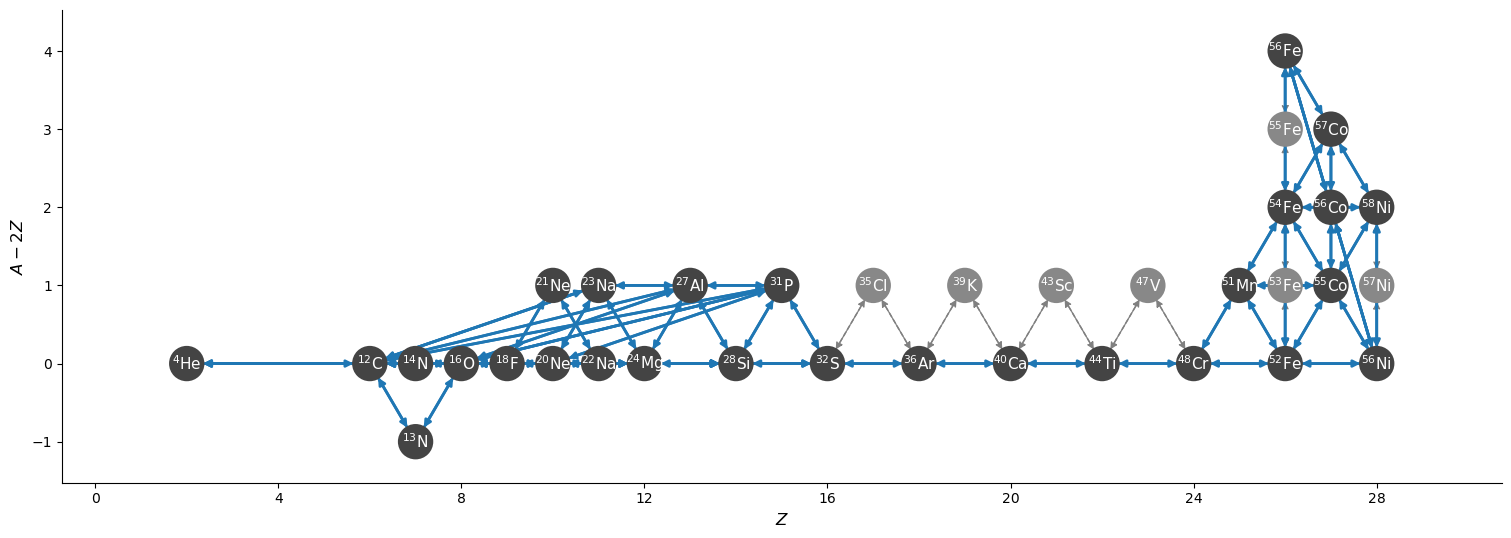

In [15]:
fig = net.plot(rotated=True, hide_xalpha=True,
               size=(1500, 550),
               node_size=550, node_font_size=11)

We see a basic $\alpha$-network with a few additional nuclei and then a small iron-group NSE set of nuclei.

## Test integration

We'll write out the network to a python module and do a test integration with it.

In [16]:
net.write_network("he_burn.py")

/ccs/home/melilly/.conda/envs/plot/lib/python3.13/site-packages/pynucastro/rates/derived_rate.py:135: UserWarning: C12 partition function is not supported by tables: set pf = 1.0 by default
  warnings.warn(UserWarning(f'{nuc} partition function is not supported by tables: set pf = 1.0 by default'))
/ccs/home/melilly/.conda/envs/plot/lib/python3.13/site-packages/pynucastro/rates/derived_rate.py:135: UserWarning: N13 partition function is not supported by tables: set pf = 1.0 by default
  warnings.warn(UserWarning(f'{nuc} partition function is not supported by tables: set pf = 1.0 by default'))
/ccs/home/melilly/.conda/envs/plot/lib/python3.13/site-packages/pynucastro/rates/derived_rate.py:135: UserWarning: N14 partition function is not supported by tables: set pf = 1.0 by default
  warnings.warn(UserWarning(f'{nuc} partition function is not supported by tables: set pf = 1.0 by default'))
/ccs/home/melilly/.conda/envs/plot/lib/python3.13/site-packages/pynucastro/rates/derived_rate.py:135

In [17]:
import he_burn

In [18]:
from scipy.integrate import solve_ivp
import numpy as np

We'll pick very high temperature and density conditions.  At these conditions, electron-captures should be important.

We'll also set the initial composition to be mostly He with some C--this has $Y_e = 0.5$ initially.

In [19]:
rho = 5.e8
T = 6.e9

X0 = np.zeros(he_burn.nnuc)
X0[he_burn.jhe4] = 0.95
X0[he_burn.jc12] = 0.05

Y0 = X0/he_burn.A

We'll include screening in the network

In [20]:
from pynucastro.screening import chugunov_2007

In [21]:
tmax = 1.0

sol = solve_ivp(he_burn.rhs, [0, tmax], Y0, method="BDF", jac=he_burn.jacobian,
                dense_output=True, args=(rho, T, chugunov_2007),
                rtol=1.e-6, atol=1.e-8)

and check if we were successful

In [22]:
sol.success

True

### Species evolution

We can plot the evolution of $X$ with time.

In [23]:
import matplotlib.pyplot as plt

Here we only plot the most abundant species.

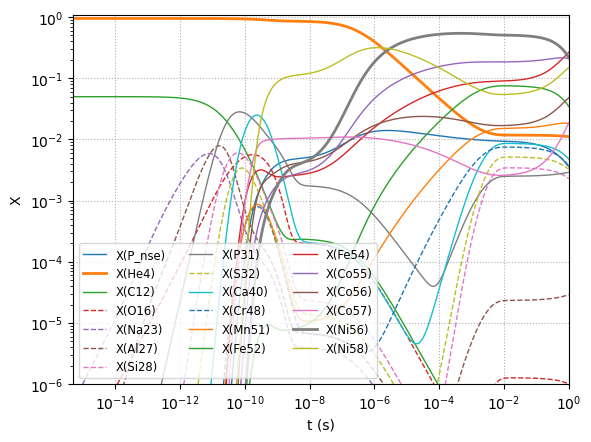

In [24]:
fig, ax = plt.subplots()

for i in range(he_burn.nnuc):
    max_X = sol.y[i, :].max() * he_burn.A[i]
    lw = 1
    ls = "--"
    if max_X > 0.5:
        lw = 2
        ls = "-"
    elif max_X > 0.01:
        lw = 1
        ls = "-"
    if max_X > 5.e-3:
        ax.loglog(sol.t, sol.y[i,:] * he_burn.A[i], lw=lw, ls=ls,
                  label=f"X({he_burn.names[i].capitalize()})")

ax.set_ylim(1.e-6, 1.1)
ax.legend(fontsize="small", ncol=3, loc=3)
ax.set_xlabel("t (s)")
ax.set_ylabel("X")
ax.grid(ls=":")
ax.margins(0)

At the very end, we see that the electron-captures on ${}^{56}\mathrm{Ni}$ are starting to decrease its abundance appreciably.

### Network flow

We can also show the flow through the network at the final time.

In [25]:
Xs = sol.y[:, -1] * he_burn.A
comp = pyna.Composition(net.unique_nuclei)
comp.set_array(Xs)

/ccs/home/melilly/.conda/envs/plot/lib/python3.13/site-packages/pynucastro/rates/derived_rate.py:135: UserWarning: C12 partition function is not supported by tables: set pf = 1.0 by default
  warnings.warn(UserWarning(f'{nuc} partition function is not supported by tables: set pf = 1.0 by default'))
/ccs/home/melilly/.conda/envs/plot/lib/python3.13/site-packages/pynucastro/rates/derived_rate.py:135: UserWarning: N13 partition function is not supported by tables: set pf = 1.0 by default
  warnings.warn(UserWarning(f'{nuc} partition function is not supported by tables: set pf = 1.0 by default'))
/ccs/home/melilly/.conda/envs/plot/lib/python3.13/site-packages/pynucastro/rates/derived_rate.py:135: UserWarning: N14 partition function is not supported by tables: set pf = 1.0 by default
  warnings.warn(UserWarning(f'{nuc} partition function is not supported by tables: set pf = 1.0 by default'))
/ccs/home/melilly/.conda/envs/plot/lib/python3.13/site-packages/pynucastro/rates/derived_rate.py:135

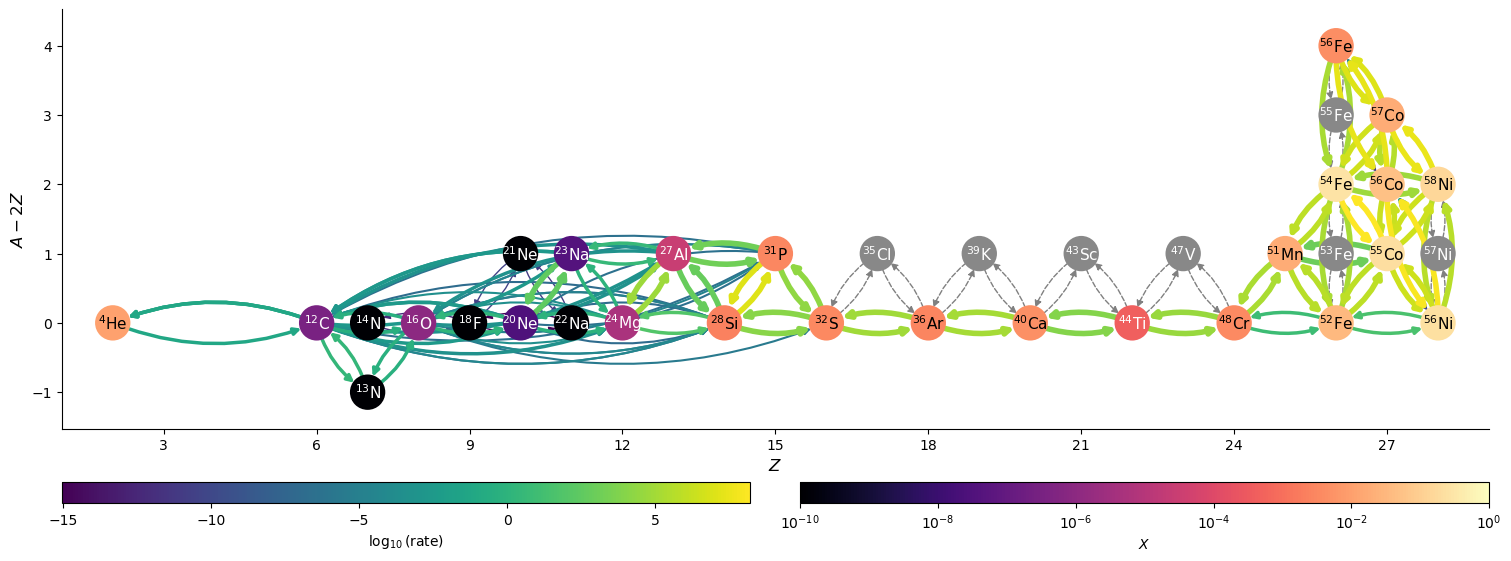

In [26]:
fig = net.plot(rho, T, comp,
               screen_func=chugunov_2007,
               rotated=True, curved_edges=True,
               hide_xalpha=True,
               color_nodes_by_abundance=True,
               size=(1500, 550),
               ydot_cutoff_value=1.e-20,
               Z_range=(1, 29),
               node_size=550, node_font_size=11)

At this point we see that we are really in the iron-group, with some lingering He.

### $Y_e$ evolution

We also see that the electron captures have decreased our $Y_e$ a bit:

In [27]:
print(f"Ye = {comp.ye:6.3f}")

Ye =  0.491
